## Collaborative rating using Movielens
Forked from [lesson5 Notebook](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson5-movielens.ipynb).

**Goal: Given a set of user-movie-ratings, predict the rating for a new user-movie combination.**

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import time
t0 = time.clock()
time.ctime(time.time())

'Tue Jul 17 10:49:51 2018'

In [3]:
import torch
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

0.4.0


## Data

Download 
[small Data](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip)  and/or
[full Data](http://files.grouplens.org/datasets/movielens/ml-latest.zip)

In [4]:
from pathlib import Path
PATH = Path('/data/movielens/ml-latest')
list(PATH.iterdir())

[PosixPath('/data/movielens/ml-latest/genome-scores.csv'),
 PosixPath('/data/movielens/ml-latest/README.txt'),
 PosixPath('/data/movielens/ml-latest/movies.csv'),
 PosixPath('/data/movielens/ml-latest/genome-tags.csv'),
 PosixPath('/data/movielens/ml-latest/ratings.csv'),
 PosixPath('/data/movielens/ml-latest/tags.csv'),
 PosixPath('/data/movielens/ml-latest/links.csv')]

In [5]:
#path='/data/movielens/ml-latest-small/'
#path='/data/movielens/ml-latest/'
path = str(PATH)

In [6]:
import pandas as pd

The movielens data contains one user-rating-movie per row:

In [7]:
rf = path+'/ratings.csv'
ratings = pd.read_csv(rf)
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


We use `userId`, `movieId` (both categorical),  and `rating` as dependent.

Just for display purposes, let's read in the movie names too.

In [8]:
mf = path+'/movies.csv'
movies = pd.read_csv(mf)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Data Exploration:
Who are the top (n) contributors? (`topUsers`)
Which are the top (n) movies? (`topMovies`)

In [9]:
topn = 15
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:topn]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:topn]

Below prints movieId and name.

In [10]:
movie_names = movies.set_index('movieId')['title'].to_dict()
topMovieslist = iter(topMovies.index)
MostRatedmovie_names = pd.Series(movie_names, index=topMovieslist)
print("Most rated Movies:")
print("Movie id\t\t\tMovie Name (Year)\n")
print(MostRatedmovie_names[0:topn])

Most rated Movies:
Movie id			Movie Name (Year)

356                                   Forrest Gump (1994)
318                      Shawshank Redemption, The (1994)
296                                   Pulp Fiction (1994)
593                      Silence of the Lambs, The (1991)
2571                                   Matrix, The (1999)
260             Star Wars: Episode IV - A New Hope (1977)
480                                  Jurassic Park (1993)
527                               Schindler's List (1993)
110                                     Braveheart (1995)
1                                        Toy Story (1995)
1210    Star Wars: Episode VI - Return of the Jedi (1983)
589                     Terminator 2: Judgment Day (1991)
1196    Star Wars: Episode V - The Empire Strikes Back...
2959                                    Fight Club (1999)
1198    Raiders of the Lost Ark (Indiana Jones and the...
dtype: object


## Create subset for Excel

We create a crosstab of the most reviewed movies and the top contributing reviewers.<br>
Panda's `crosstab` computes a simple cross-tabulation of two (or more) factors. 
By default computes a frequency table of the factors, unless an array of values and an aggregation function are passed.
Here we pass the top users, top movies, and top ratings, with an aggregation function of `np.sum`
```
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)
```
We copy this table to Excel for a simple example. (Not necessary for the modeling below)

In [11]:
import numpy as np

In [12]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,1196,1198,1210,2571,2959
userId,,,,,,,,,,,,,,,
8659,4.0,5.0,4.0,4.5,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0
24025,3.0,4.0,2.5,5.0,4.5,3.5,4.5,5.0,4.5,4.0,1.5,4.5,2.0,4.5,4.5
45811,4.0,3.5,4.0,4.5,4.5,3.5,4.0,4.5,4.0,4.0,4.0,4.0,4.0,4.0,3.5
70648,4.0,4.0,4.0,4.5,4.0,3.5,4.0,4.0,4.0,4.5,4.0,4.0,4.0,4.0,4.5
98415,3.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.5,2.5,4.0,3.0,4.0,2.0
98787,4.0,4.0,3.0,5.0,5.0,2.0,2.5,3.5,5.0,4.0,5.0,5.0,3.0,4.0,1.0
107720,3.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0,5.0,4.0
172224,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0
179792,5.0,4.0,5.0,5.0,4.5,4.5,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0


## Collaborative filtering

Use `CollabFilterDataset.from_csv` to load the ratings file columns userid, movieId and rating, and return an object.

In [13]:
from fastai.column_data import CollabFilterDataset  #*

In [14]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')

In [15]:
from fastai.dataset import get_cv_idxs

We create a validation set by picking random set of ID’s. 
- `wd` is a weight decay for L2 regularization
- `n_factors` is size of embedding matrix.

In [16]:
val_idxs = get_cv_idxs(len(ratings))   # validation indeces
n_factors = 50  # size of embedding matrix
bs = 64  # Batch size

In [17]:
from torch import optim

get a learner that is suitable for the model data, and then fit the model:
```
get_learner(self, n_factors, val_idxs, bs, **kwargs) 
```
returns a learner

In [18]:
learn = cf.get_learner(n_factors, val_idxs, bs, opt_fn=optim.Adam)

In [19]:
lr = 1e-2
wd = 2e-4   # Weight decay

`learn.fit` args: 
* `lrs` (float or list(float)): learning rate for the model
* `n_cycle` (int): number of cycles (or iterations) to fit the model for
* `wds` (float or list(float)): weight decay parameter(s).
* `kwargs`: other arguments

**NB: Below step takes hours about 3 hours to complete on the bigger dataset....Wall time: 2h 57min 14s
On the smaller dataset only 21 sec.**

In [20]:
%time lf = learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2) #, use_wd_sched=True)

epoch      trn_loss   val_loss                                      
    0      0.969431   0.981526  
    1      0.983727   0.983423                                      
    2      0.983136   0.982232                                      

CPU times: user 1h 58min 18s, sys: 31min 30s, total: 2h 29min 48s
Wall time: 2h 27min 19s


Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We need to take the square root of the loss, since we use plain MSE.

In [21]:
lf

[0.9822320747849846]

In [22]:
from math import sqrt
sqrt(lf[0])

0.9910762204719598

Looking good - we've found a solution (same/better) than any of those benchmarks! Let's take a look at how the predictions compare to actuals for this model.

In [23]:
preds = learn.predict()

In [24]:
import seaborn as sns

In [25]:
sns.__version__

'0.8.1'

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


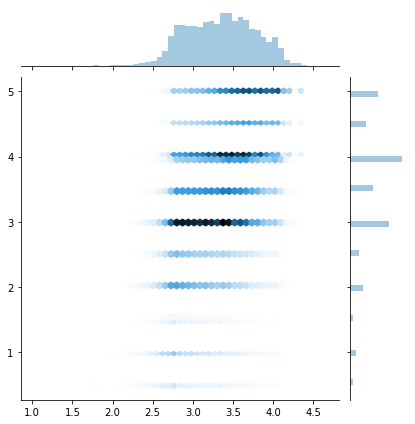

In [26]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

## Analyze results

### Movie bias

In [27]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [28]:
learn.models.model  # this is where the model is kept

EmbeddingDotBias(
  (u): Embedding(270896, 50)
  (i): Embedding(45115, 50)
  (ub): Embedding(270896, 1)
  (ib): Embedding(45115, 1)
)

In [29]:
m=learn.model; m.cuda()   # shortcut

EmbeddingDotBias(
  (u): Embedding(270896, 50)
  (i): Embedding(45115, 50)
  (ub): Embedding(270896, 1)
  (ib): Embedding(45115, 1)
)

One nice thing about Pytorch is that all layers can be invoked as if they were functions, e.g., `m.ib()` returns the movie bias.  

Pytorch Layers require Variables, not tensors, so they can compute the gradients... 
So we must pass Variables to models.
But in Pytorch 0.4 there will no longer need Variables, ie we can pass the tensors directly! 

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).  Each movie has a single bias

In [30]:
from fastai.learner import V #*  V wraps it into a Variable

In [31]:
m.ib(V(topMovieIdx))  # passing a variable to the model for all the top indeces, returns a Variable of size 3000 with the biases

tensor([[ 1.2725e+00],
        [ 1.7482e+00],
        [ 1.3746e+00],
        ...,
        [ 2.6468e-01],
        [ 2.5495e-02],
        [ 1.4372e-01]], device='cuda:0')

In [32]:
from fastai.core import to_np  # to_np returns an np array

In [33]:
movie_bias = to_np(m.ib(V(topMovieIdx)))   #to_np is convert to numpy (fastai shortcut)

In [34]:
movie_bias    # now in numpy

array([[1.27254],
       [1.74821],
       [1.37457],
       ...,
       [0.26468],
       [0.02549],
       [0.14372]], dtype=float32)

JH approach, always use **numpy** unless you need GPU or a Variable.   Fastai does as much as possible in numpy.

Now grab each movie along with its bias term, with zip we get it into a list of tuples, 
so we can then use it in a list comprehension to iterate over all the the movies.
Lets get all the movie ratings.

In [35]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

About sorting key — Python has itemgetter function but plain lambda is just one more character,
so we use lambda as the key sorter, and show the "top" (worst) 15 movies

In [36]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.7139285, 'Battlefield Earth (2000)'),
 (-0.5602952, 'Speed 2: Cruise Control (1997)'),
 (-0.50666773, 'Spice World (1997)'),
 (-0.4645399, 'Home Alone 3 (1997)'),
 (-0.4582885, 'Anaconda (1997)'),
 (-0.452565, 'Batman & Robin (1997)'),
 (-0.44380373, 'Barb Wire (1996)'),
 (-0.44025883, 'Super Mario Bros. (1993)'),
 (-0.421409, 'Grease 2 (1982)'),
 (-0.40168524, 'Howard the Duck (1986)'),
 (-0.39762554, 'Superman IV: The Quest for Peace (1987)'),
 (-0.39482275, 'Police Academy 6: City Under Siege (1989)'),
 (-0.39363483, 'Catwoman (2004)'),
 (-0.38054696, 'Stop! Or My Mom Will Shoot (1992)'),
 (-0.37966123, 'Street Fighter (1994)')]

Equivalent to above (with lambda) but using the `itemgetter` operator.

In [37]:
from operator import itemgetter
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.7139285, 'Battlefield Earth (2000)'),
 (-0.5602952, 'Speed 2: Cruise Control (1997)'),
 (-0.50666773, 'Spice World (1997)'),
 (-0.4645399, 'Home Alone 3 (1997)'),
 (-0.4582885, 'Anaconda (1997)'),
 (-0.452565, 'Batman & Robin (1997)'),
 (-0.44380373, 'Barb Wire (1996)'),
 (-0.44025883, 'Super Mario Bros. (1993)'),
 (-0.421409, 'Grease 2 (1982)'),
 (-0.40168524, 'Howard the Duck (1986)'),
 (-0.39762554, 'Superman IV: The Quest for Peace (1987)'),
 (-0.39482275, 'Police Academy 6: City Under Siege (1989)'),
 (-0.39363483, 'Catwoman (2004)'),
 (-0.38054696, 'Stop! Or My Mom Will Shoot (1992)'),
 (-0.37966123, 'Street Fighter (1994)')]

Now reverse sorting to find the top rated movies

In [38]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(1.7482085, 'Shawshank Redemption, The (1994)'),
 (1.5562092, 'Godfather, The (1972)'),
 (1.5369654, 'Usual Suspects, The (1995)'),
 (1.5024856, "Schindler's List (1993)"),
 (1.4696391, 'Fight Club (1999)'),
 (1.4047357, 'Godfather: Part II, The (1974)'),
 (1.3939091, "One Flew Over the Cuckoo's Nest (1975)"),
 (1.3875325, 'Silence of the Lambs, The (1991)'),
 (1.3789401, 'Matrix, The (1999)'),
 (1.3745747, 'Pulp Fiction (1994)'),
 (1.3513808, 'Star Wars: Episode IV - A New Hope (1977)'),
 (1.3333501, 'Dark Knight, The (2008)'),
 (1.3316631, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (1.3292571, 'Casablanca (1942)'),
 (1.3244933,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)')]

### Embedding interpretation

We can now do the same thing to look at the embeddings. (m.i)

In [39]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 dimensional space.  Linear techniques work well for this type of embedings.
Turns out PCA is very similar to Singular Value Decomposition (SVD) which from time to time turns out in DL.

In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)   # find 3 linear combinations that are different from each other as possible
movie_pca = pca.fit(movie_emb.T).components_   # grab the 3 components

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/sklearn/decomposition/pca.py:505: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()


In [41]:
movie_pca.shape

(3, 3000)

In [42]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

We don't know apriori what is the interpretation for the latent factor identified by each component....
Here's the 1st component, the principal axis. So lets try to give it an interpretation....  JH called it 'easy watching' vs 'serious'.

In [43]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.07253562, 'X-Men (2000)'),
 (0.06145416, 'Sense and Sensibility (1995)'),
 (0.05639893, 'Neighbors (2014)'),
 (0.0548314, 'Shane (1953)'),
 (0.053857587, 'Dallas Buyers Club (2013)'),
 (0.053222336, 'Beavis and Butt-Head Do America (1996)'),
 (0.053135112, 'K-PAX (2001)'),
 (0.053102475, 'Serenity (2005)'),
 (0.052920595, 'Whale Rider (2002)'),
 (0.05242061, 'Lady Eve, The (1941)')]

In [44]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.06364075, 'Aladdin (1992)'),
 (-0.06359645, 'Beauty of the Day (Belle de jour) (1967)'),
 (-0.061429996, 'Tenacious D in The Pick of Destiny (2006)'),
 (-0.054152057, "He's Just Not That Into You (2009)"),
 (-0.0541253, 'Die Hard: With a Vengeance (1995)'),
 (-0.054102324, 'Any Given Sunday (1999)'),
 (-0.05382149, 'Her (2013)'),
 (-0.053010277, 'Big Hero 6 (2014)'),
 (-0.052214168, 'Aristocats, The (1970)'),
 (-0.050191775, 'Far from Heaven (2002)')]

In [45]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the $2nd$ component. More difficult to interpret...  To JH seems to be 'CGI' vs 'dialog driven'.

In [46]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.061371174, 'Maltese Falcon, The (1941)'),
 (0.05780575, 'Pelican Brief, The (1993)'),
 (0.05536572, 'Sydney (Hard Eight) (1996)'),
 (0.05515335, 'Hobbit: The Desolation of Smaug, The (2013)'),
 (0.054097064, 'Gallipoli (1981)'),
 (0.052923013, 'Saw IV (2007)'),
 (0.05220475, 'Nick of Time (1995)'),
 (0.05165875, "Sorcerer's Apprentice, The (2010)"),
 (0.05159869, 'Forrest Gump (1994)'),
 (0.0491049, 'Lethal Weapon 2 (1989)')]

In [47]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.06030934, 'Breakdown (1997)'),
 (-0.058430325, 'Mary Poppins (1964)'),
 (-0.05526794, 'Snow Falling on Cedars (1999)'),
 (-0.054327257, 'Scary Movie 3 (2003)'),
 (-0.05391873, 'Signs (2002)'),
 (-0.053815253, 'Natural Born Killers (1994)'),
 (-0.05256044, 'Age of Innocence, The (1993)'),
 (-0.05094003, 'Jack (1996)'),
 (-0.050714, 'Casino Royale (2006)'),
 (-0.050336666, 'Finding Neverland (2004)')]

#### Plot
We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

In [48]:
from matplotlib import pyplot as plt
import numpy as np

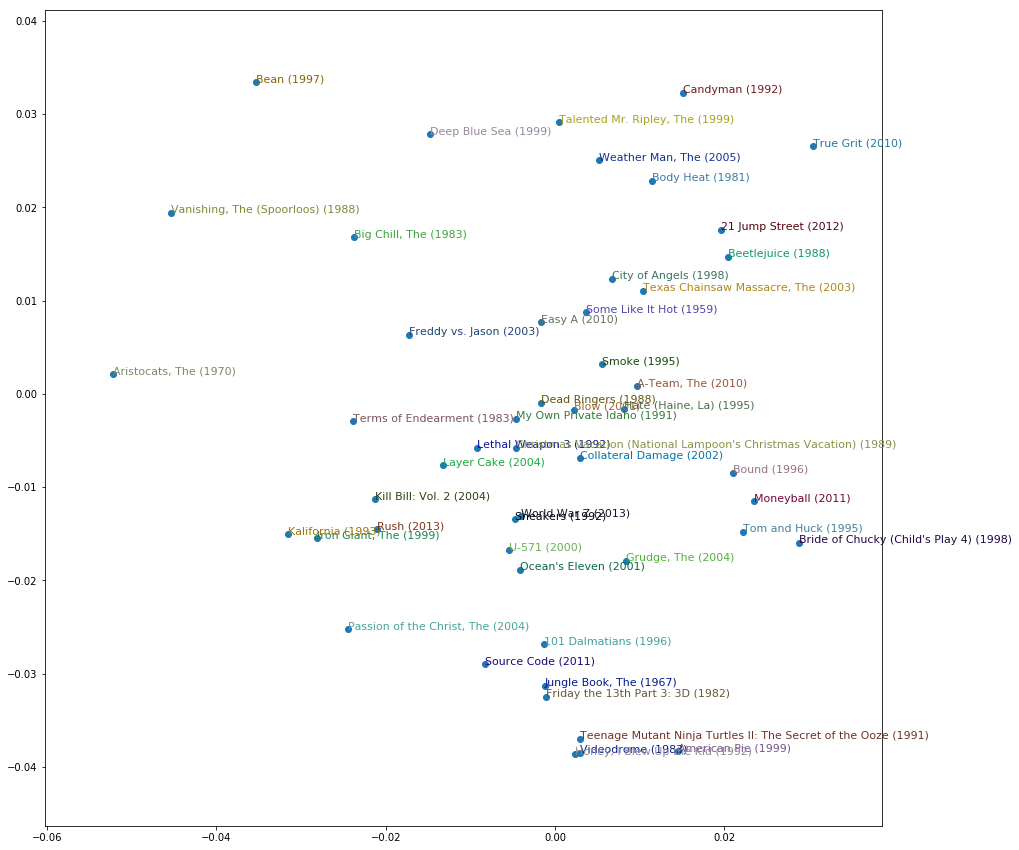

In [49]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collab filtering from scratch

### Dot product example (aka inner product)

In [50]:
from fastai.core import T

In [51]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(tensor([[ 1.,  2.],
         [ 3.,  4.]], device='cuda:0'), tensor([[  2.,   2.],
         [ 10.,  10.]], device='cuda:0'))

In [52]:
a*b   # element by element

tensor([[  2.,   4.],
        [ 30.,  40.]], device='cuda:0')

In [53]:
(a*b).sum(1)   # the dot product

tensor([  6.,  70.], device='cuda:0')

In [54]:
import torch.nn as nn

In [55]:
class DotProduct(nn.Module):
    def forward(self, u, m): return (u*m).sum(1)

In [56]:
model=DotProduct()

In [57]:
model(a,b)

tensor([  6.,  70.], device='cuda:0')

### Dot product model

Building a more complex module 
[41:31]
This implementation has two additions to the DotProduct class:

- Two `nn.Embedding` matrices
- Look up our users and movies in above embedding matrices

It is quite possible that user ID’s are not contiguous which makes it hard to use as an index of embedding matrix. So we will start by creating indexes that starts from zero and contiguous and replace ratings.userId column with the index by using Panda’s apply function with an anonymous function lambda and do the same for ratings.movieId .

In [58]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [59]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies)
        return (u*m).sum(1).view(-1,1)     # fixed from https://github.com/fastai/fastai/issues/599

Note that __init__ is a constructor, now needed to keep track of “states” (how many movies, users, factors, etc). 
We initialized the weights to random numbers between 0 and 0.05 and you can find more information about a standard algorithm for weight initialization, [“Kaiming Initialization”](http://www.jefkine.com/deep/2016/08/08/initialization-of-deep-networks-case-of-rectifiers/)
(PyTorch has He initialization utility function but we are doing things from scratch) [46:58].

**NB: Below changes for Pytorch 0.4 where Tensors and Variables have merged **

`Embedding` is not a tensor but a **variable**. 
A variable does the same operations as a tensor **and** it also does automatic differentiation. 
To pull a tensor out of a variable, call data attribute. 
All the tensor functions have a variation with trailing underscore (e.g. uniform_) will do things in-place.

In [60]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [61]:
from fastai.column_data import ColumnarModelData

We use `ColumnarModelData` (eg from Rossmann notebook), and that is the reason why there are both categorical and continuous variables in 
```
def forward(self, cats, conts) 
```
function in `EmbeddingDot class` [50:20]. 
Since we do not have continuous variables, we  ignore conts, and use the 1st and 2nd columns of cats as users and movies. 
NB: they are mini-batches of users and movies. 
Do **not** manually loop through mini-batches because you will not get GPU acceleration. 
Process a whole mini-batch at a time as you see in line 3 and 4 of forward function above [51:00–52:05].

In [62]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [63]:
x.shape, y.shape

((26024289, 2), (26024289,))

In [64]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

`optim` gives us the optimizers in PyTorch. 
`model.parameters()` is inherited from `nn.Modules` that gives us all the weight to be updated/learned.

In [65]:
from fastai.learner import fit
from fastai.conv_learner import F 

In [66]:
%pdb

Automatic pdb calling has been turned ON


`fit` below is from fast.ai library [54:40] and is closer to the PyTorch approach compared to learner.fit(). 
`fit` will not have features like SGDR or DLR. 

In [67]:
%time fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                     
    0      1.326462   1.329343  
    1      1.366212   1.296844                                     
    2      1.255484   1.287181                                     

CPU times: user 1h 16min 16s, sys: 19min 38s, total: 1h 35min 55s
Wall time: 1h 31min 6s


[1.2871812823981081]

In [68]:
from fastai.layer_optimizer import set_lrs
set_lrs(opt, 0.01)

In [69]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                      
    0      0.958996   1.002429  
    1      0.921949   0.994401                                      
    2      0.955127   0.992364                                      



[0.9923643714143565]

### Bias
 to adjust for generally popular movies or generally enthusiastic users.

In [70]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

In [71]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze()
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res.view(-1,1)

`squeeze()` is PyTorch version of broadcasting [1:04:11] for more information, see Machine Learning class or numpy documentation.

We squish the ratings so that they are between 1 and 5.
By putting the prediction through sigmoid results in numbers between 1 and 0. 
So in this case, we can multiply that by 4 and add 1 — which will result in number between 1 and 5.

`F` is a PyTorch functional (torch.nn.functional) that contains all functions for tensors, and is imported as F in most cases.

In [72]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [73]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                      
    0      0.972152   0.967452  
    1      0.953689   0.967344                                      
    2      0.994291   0.967647                                      



[0.9676474408504044]

In [74]:
from fastai.layer_optimizer import set_lrs

In [75]:
set_lrs(opt, 1e-2)

In [76]:
%time fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                      
    0      0.981206   0.957722  
    1      0.932338   0.957177                                      
    2      0.95279    0.957359                                      

CPU times: user 1h 28min 53s, sys: 19min 54s, total: 1h 48min 48s
Wall time: 1h 44min 38s


[0.9573591365070583]

### Mini net

Neural Net Version [1:17:21]
We go back to excel sheet to understand the intuition. Notice that we create user_idx to look up Embeddings just like we did in the python code earlier. If we were to one-hot-encode the user_idx and multiply it by user embeddings, we will get the applicable row for the user. If it is just matrix multiplication, why do we need Embeddings? It is for computational performance optimization purposes.
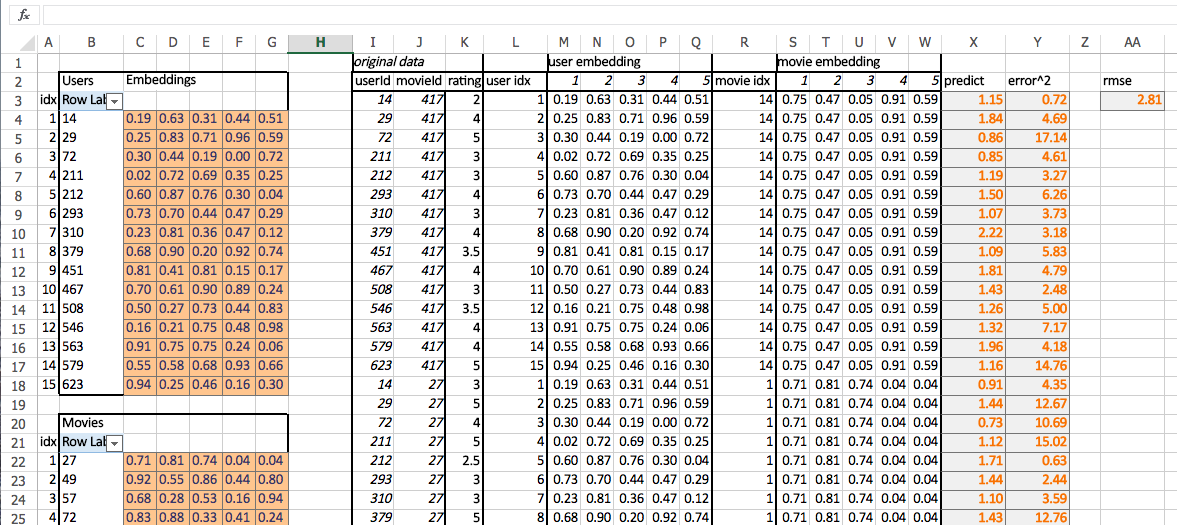

Rather than calculating the dot product of user embedding vector and movie embedding vector to get a prediction, 
we will concatenate the two and feed it through neural net.

In [77]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

`nn.Linear` already includes a bias.
Notice that we no longer has bias terms since Linear layer in PyTorch already has a built in bias. 
- `nh` is a number of activations a linear layer creates (“num hidden”).
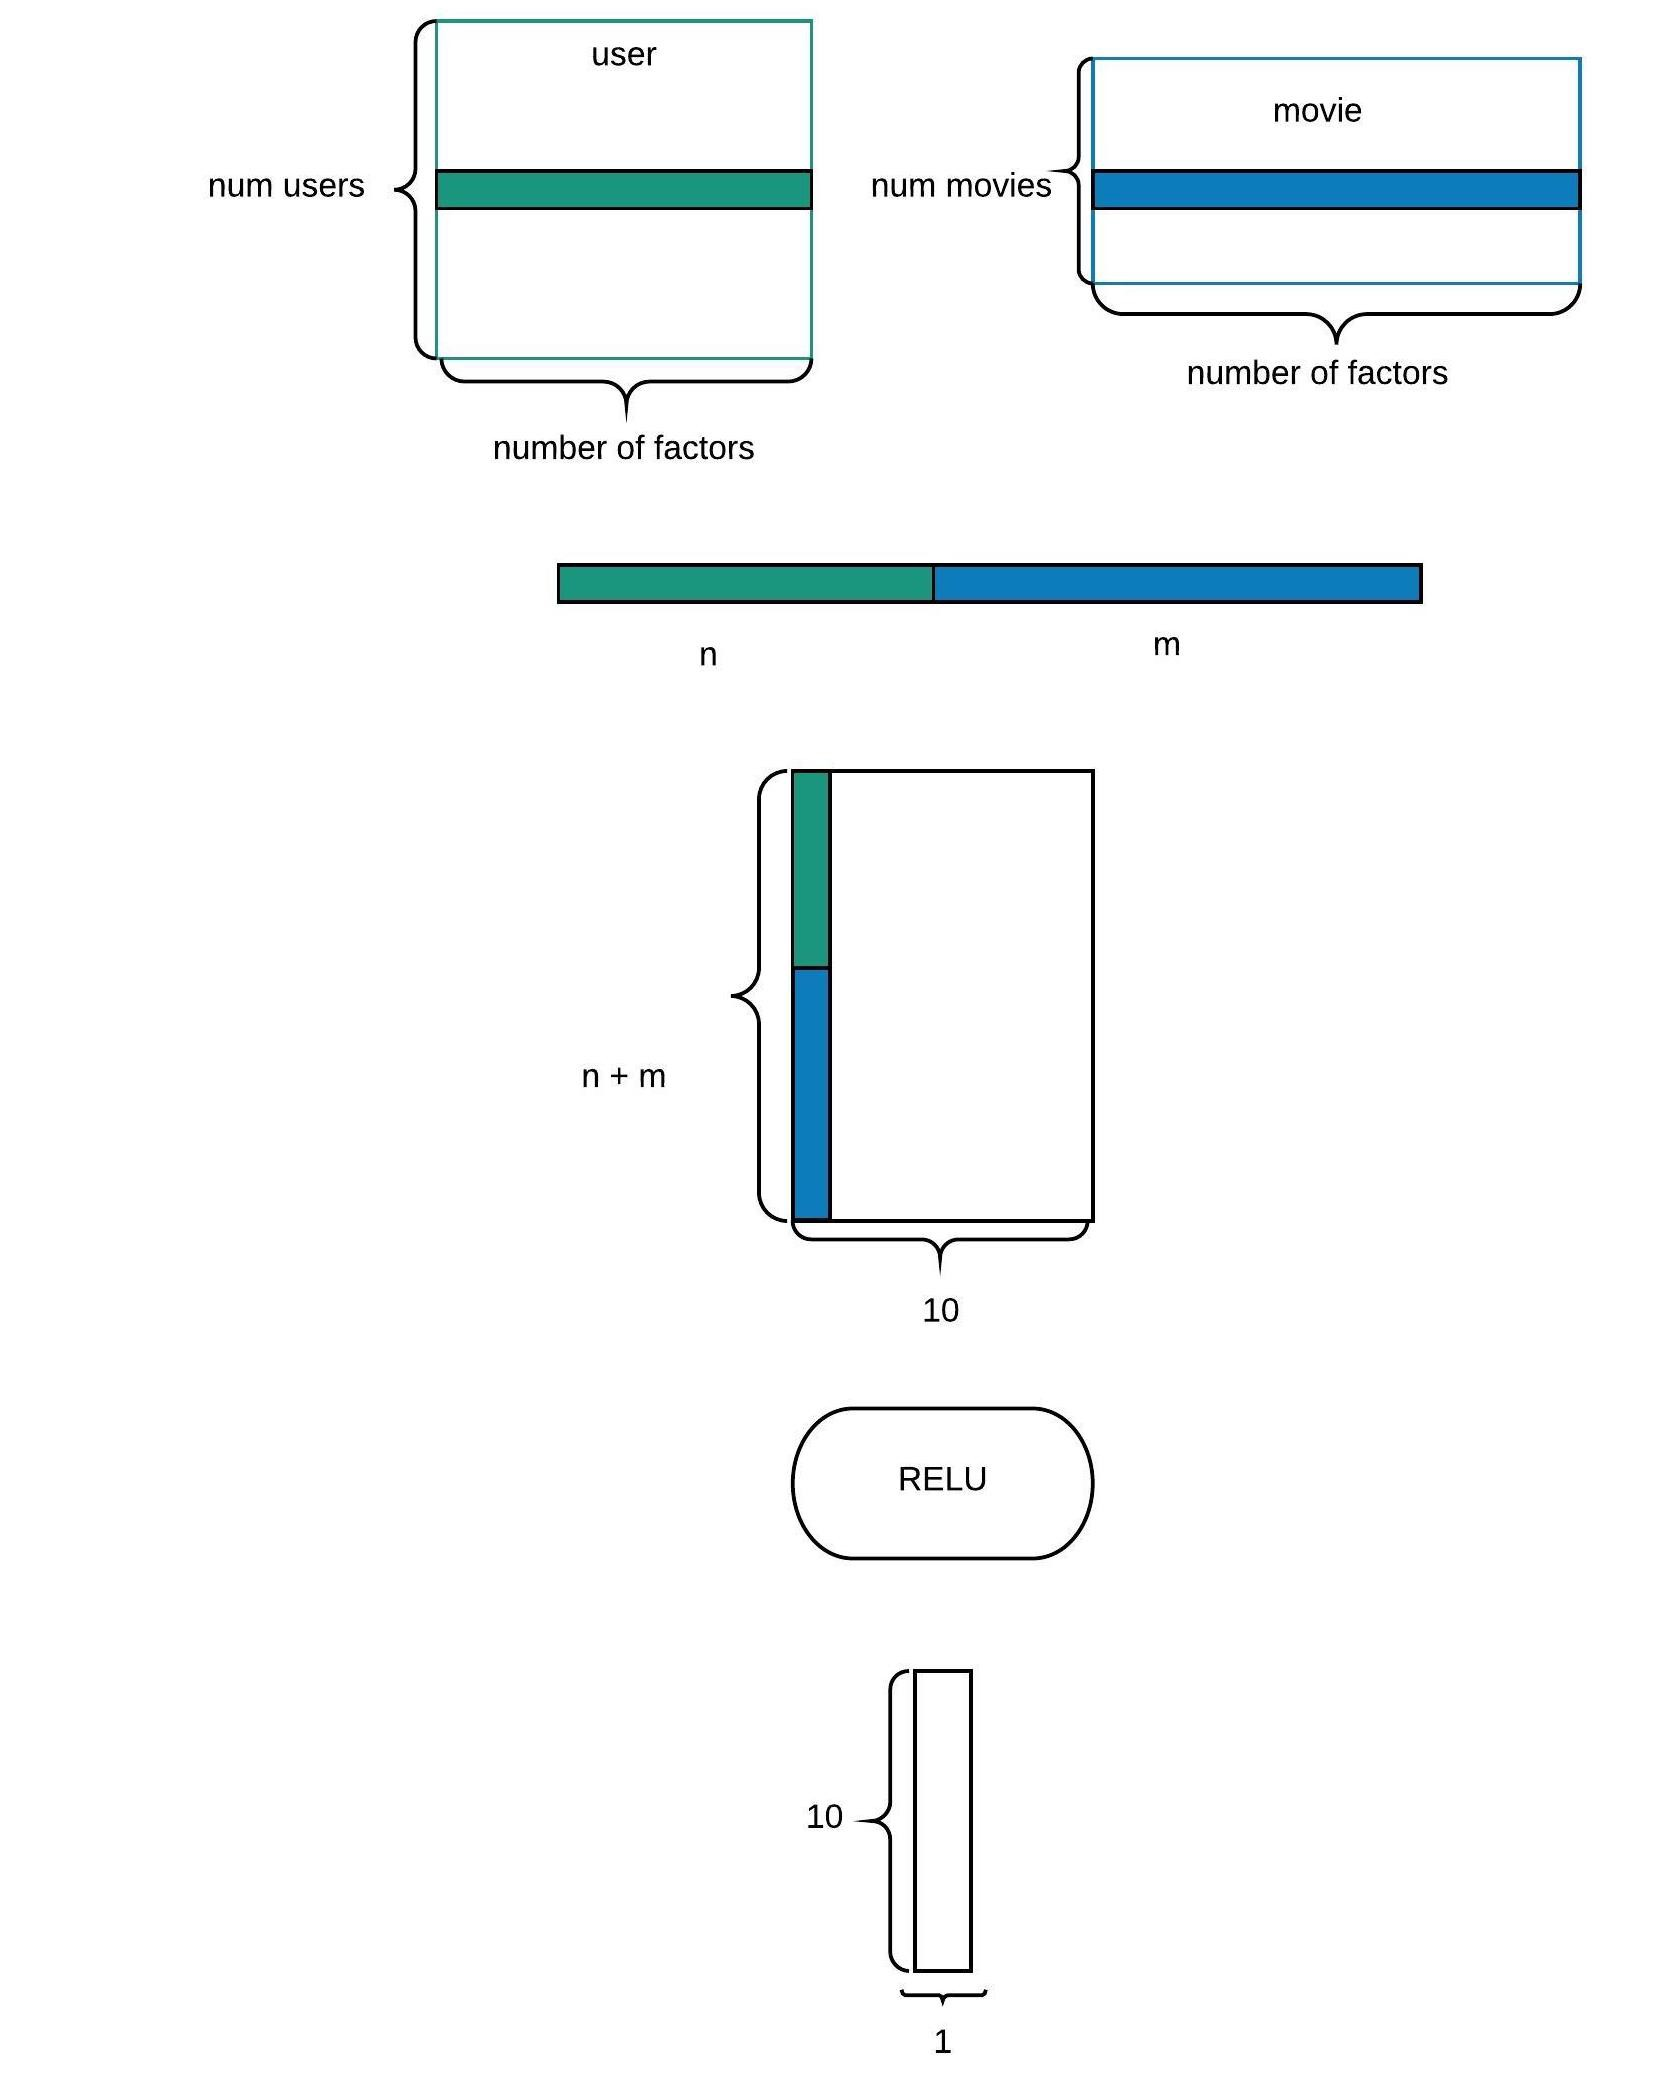

It only has one hidden layer, so maybe not “deep”, but this is definitely a neural network.



In [78]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [79]:
%time fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                      
    0      0.872117   0.836276  
    1      0.894725   0.838563                                       
    2      0.862207   0.835291                                      

CPU times: user 2h 22min 26s, sys: 36min 27s, total: 2h 58min 54s
Wall time: 2h 54min 37s


[0.8352905986744312]

Notice that the loss functions are also in F (here, it s mean squared loss).

Now that we have neural net, there are many things we can try:
- Add dropouts
- Use different embedding sizes for user embedding and movie embedding
- Not only user and movie embeddings, but append movie genre embedding and/or timestamp from the original data.
- Increase/decrease number of hidden layers and activations
- Increase/decrease regularization

In [80]:
set_lrs(opt, 1e-3)

In [81]:
%time fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                      
    0      0.889823   0.836507  
    1      0.896593   0.836528                                      
    2      0.886209   0.836646                                      

CPU times: user 2h 9min 24s, sys: 30min 41s, total: 2h 40min 5s
Wall time: 2h 36min 12s


[0.8366463227172667]

## END

In [82]:
t1 = time.clock()
time.ctime(time.time()), (t1 - t0)

('Wed Jul 18 01:22:33 2018', 54088.962628)